In [2]:
#Mount Google Drive
# link to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/content/drive/My Drive/Colab Notebooks/Project')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Project/Hit-Song-Prediction')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Project/Hit-Song-Prediction/SpotifyConnection.py')

In [9]:
!pip install spotipy

In [10]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from Playlist import Playlist
from DataProcessing import normalize_dataframe, DataInformation, SpotifyTracksDataset


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [132]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
sp = get_spotify_connection()

pl = Playlist("2sRZldX6n9oaII70OoO3zB")
pl.load_playlist_tracks(sp)
PL.save_playlist(pl)

pl = PL.load_playlist("playlist_2sRZldX6n9oaII70OoO3zB")
df = pl.load_playlist_df(sp)
PL.save_playlist(pl)

pl = PL.load_playlist("playlist_2sRZldX6n9oaII70OoO3zB")
df = pl.get_playlist_df(cols=DataInformation.list())
normalized_df = normalize_dataframe(df)
normalized_df.head()

Loading playlist 2sRZldX6n9oaII70OoO3zB tracks...
Done.
Saved playlist into file: playlist_2sRZldX6n9oaII70OoO3zB
Loaded playlist from file: playlist_2sRZldX6n9oaII70OoO3zB
Loading playlist 2sRZldX6n9oaII70OoO3zB track information into DataFrame...
Done.
Saved playlist into file: playlist_2sRZldX6n9oaII70OoO3zB
Loaded playlist from file: playlist_2sRZldX6n9oaII70OoO3zB


,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,popularity
0,0.068542,0.000000,1.0,0.8,0.111444,0.805471,0.595076,0.0,0.145511,0.858757,0.079468,0.409,0.616788,0.76
1,0.066175,0.909091,0.0,0.8,0.344376,0.701114,0.714348,0.0,0.083591,0.896666,0.373404,0.615,0.627561,0.63
2,0.067781,0.727273,0.0,1.0,0.241966,0.493414,0.366554,0.0,0.108359,0.787748,0.056489,0.161,0.311547,0.75
3,0.055939,0.727273,1.0,1.0,0.127508,0.597771,0.653209,0.0,0.042931,0.865515,0.356383,0.691,0.569657,0.29
4,0.070991,0.090909,1.0,0.8,0.035641,0.834853,0.734394,0.0,0.312693,0.874820,0.065213,0.393,0.447603,0.75


In [56]:
def train_validate_test_split(df, train_percent=.7, validate_percent=.15, seed=50):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [57]:
train, validate, test = train_validate_test_split(normalized_df)

In [88]:
class TestNet(nn.Module):
    def __init__(self):
        super(TestNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(13, 50),
            nn.Sigmoid(),
            nn.Linear(50, 80),
            nn.Sigmoid(),
            nn.Linear(80, 100),
            nn.Sigmoid(),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.layers(x)
        return x

In [89]:
net = TestNet()

In [90]:
def train_net(model, train, validate, num_epochs=5, learning_rate=1e-4):
    
    train_ds = SpotifyTracksDataset(train)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)

    val_ds = SpotifyTracksDataset(validate)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs, shuffle=True)
    
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    epochs, iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], [], []
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        error_train = 0
        error_val = 0
        for features, targets in train_loader:
            optimizer.zero_grad()
            out = net(features)
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()
            error_train += (targets - out).abs().sum().item()

        #save the current training info
        iters.append(n)
        train_loss.append(loss.item())
            

        for features, targets in val_loader:
            optimizer.zero_grad()
            out = net(features)
            loss = criterion(out, targets)
            error_val += (targets - out).abs().sum().item()

        val_loss.append(loss.item())

        #get accuracy
        train_acc.append(error_train/len(train_ds)) 
        val_acc.append(error_val/len(val_ds))
        n += 1
        print(("Epoch {}: Training Accuracy {} |"+"Validation Accuracy {}").format(epoch, train_acc[epoch], val_acc[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0: Training Accuracy 0.2464952919934247 |Validation Accuracy 0.24631870950309975
Epoch 1: Training Accuracy 0.2467146058588167 |Validation Accuracy 0.24529859684046032
Epoch 2: Training Accuracy 0.2422448570168192 |Validation Accuracy 0.22698713159098208
Epoch 3: Training Accuracy 0.22646854003105243 |Validation Accuracy 0.21184177711172011
Epoch 4: Training Accuracy 0.21545654324632674 |Validation Accuracy 0.20240358588764967
Epoch 5: Training Accuracy 0.21252488916480367 |Validation Accuracy 0.2042528113115181
Epoch 6: Training Accuracy 0.21095225555733188 |Validation Accuracy 0.20103618068602477
Epoch 7: Training Accuracy 0.20925337708169853 |Validation Accuracy 0.20608643362823043
Epoch 8: Training Accuracy 0.20937000713824233 |Validation Accuracy 0.20282123158278975
Epoch 9: Training Accuracy 0.20794036036469585 |Validation Accuracy 0.19934593878903437
Epoch 10: Training Accuracy 0.20758152181542094 |Validation Accuracy 0.19289183327295248
Epoch 11: Training Accuracy 0.20729

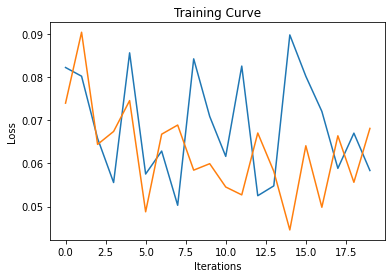

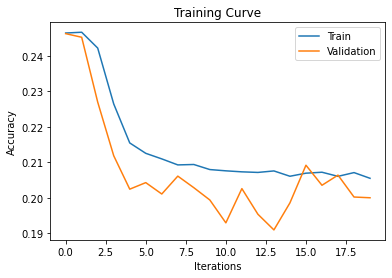

Final Training Accuracy: 0.20547334270516948
Final Validation Accuracy: 0.1999761196016108


In [91]:
train_net(net, train, validate, 20, 1e-3)

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [128]:
features = ["duration", "key", "mode", "time_signature", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo"]
training = normalized_df.sample(frac = 0.8,random_state = 420)
# add to code before training SGDRegressor model

X_train = training[features]
y_train = training['popularity']
X_test = normalized_df.drop(training.index)[features]

scaler = StandardScaler()
scaler.fit(X_train)
X_t = scaler.transform(X_train)

In [129]:
X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_train, test_size = 0.2, random_state = 420)

In [141]:
SGD_Model = linear_model.SGDRegressor()
SGD_Model.fit(X_train, y_train)
SGD_Predict = SGD_Model.predict(X_valid)
predict = pd.DataFrame(SGD_Predict)
predict = predict.reset_index(drop=True)
val = pd.DataFrame(y_valid)
val = val.reset_index(drop=True)
compare = pd.concat([predict, val], axis=1)
compare


,0,popularity
0,0.470431,0.80
1,0.478930,0.63
2,0.123215,0.30
3,0.460689,0.03
4,0.478892,0.61
...,...,...
875,0.450532,0.06
876,0.464413,0.63
877,0.489867,0.02
878,0.483063,0.67
